# Spoken Digit Recognition

Firstly import needed libraries:

In [2]:
try:
    # Wavfile libraries
    from scipy.io.wavfile import read
    import wavio as wv
    # ML libraries
    from sklearn.model_selection import train_test_split
    from librosa import get_duration
    from sklearn.metrics import f1_score
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    # FFT libs
    from scipy.fft import fft, ifft, fftfreq
    # Own libs
    from utils import *
    # Other
    import os
    import re
    %matplotlib widget
except:
    print("Something is wrong")

2023-02-18 14:02:39.963131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 14:02:40.244951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 14:02:40.244992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-18 14:02:40.283670: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-18 14:02:41.044008: W tensorflow/stream_executor/platform/de

Some functions to not duplicate code:

In [3]:
# Fast plotting
def plot_signal(X, Y, xlabel, ylabel, title):
    plt.figure()
    plt.plot(X, Y)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

Then dataset should be downloaded (source: https://github.com/TaskAccount/free-spoken-digit-dataset/tree/master/recordings). GlobalVariables is class created to make it easier to store significant data:

In [4]:

# ---------------------------------------------------------------------------------
# Read all recordings
records_dir = os.path.dirname(os.path.realpath('__file__')) + '/recordings/'
GlobVar = GlobalVariables()
save_or_load_csv = 1
LABEL_NUMBER = 5

if save_or_load_csv == 1:
    for wavfile in os.listdir(records_dir):
        number = int(wavfile[0])
        number_vec = np.zeros(LABEL_NUMBER)
        number_vec[number] = 1
        name, sample_id = re.findall(r'_(.*)_(.*).wav', wavfile)[0]
        signal = np.array(read(records_dir + wavfile)[1], dtype=float)
        f, y_signal = read(records_dir + wavfile)


        if GlobVar.MAX_SAMPLES < signal.shape[0]:
            GlobVar.MAX_SAMPLES = signal.shape[0]
        if GlobVar.MAX_VALUE < np.max(signal):
            GlobVar.MAX_VALUE = np.max(signal)
        if GlobVar.MIN_SAMPLES > signal.shape[0]:
            GlobVar.MIN_SAMPLES = signal.shape[0]

        data = {
            "id": sample_id,
            "name": name,
            "duration": float(get_duration(filename=records_dir + wavfile)),
            "signal": [signal],
            "signal_shape": signal.shape,
            "number_vec": [number_vec.tolist()],
            "number": [number]
        }

        GlobVar.all_records.append(data)
        GlobVar.df_records = pd.concat(
            [GlobVar.df_records, pd.DataFrame(data)], ignore_index=True, axis=0)
        GlobVar.sorted_records[number].append(signal)

    for index, sig in enumerate(GlobVar.df_records["signal"]):
        zero_vec = np.zeros(GlobVar.MAX_SAMPLES)
        zero_vec[0:sig.shape[0]] = sig/GlobVar.MAX_VALUE
        GlobVar.df_records["signal"][index] = zero_vec.tolist()
        GlobVar.df_records["signal_shape"][index] = zero_vec.shape[0]
        GlobVar.all_records[index] = zero_vec.tolist()
        GlobVar.sorted_records[GlobVar.df_records["number"][index]] = zero_vec.tolist()

    # GlobVar.df_records.to_parquet('dataframe.parquet')
if save_or_load_csv == 2:
    GlobVar.df_records = pd.read_parquet('dataframe.parquet')

y_fft_list = []
x_fft_list = []
for signal in GlobVar.df_records["signal"]:
    T = 1.0/f
    N = len(signal)
    N_fft = N//2
    y_fft = fft(signal,2**14)
    y_fft = np.abs(y_fft)
    y_fft = y_fft[0:N_fft]
    y_fft = y_fft/y_fft.max()
    x_fft = fftfreq(N, T)[:N_fft]
    y_fft_list.append(y_fft)
    x_fft_list.append(x_fft)
    if False:    
        plot_signal(x_fft, np.abs(y_fft[:N_fft]), "Frequency [Hz]",
                    "Amplitude", f"Number {number} of person {name}")
        plt.show()

GlobVar.df_records.insert(loc=len(GlobVar.df_records.columns), column="y_fft", value=y_fft_list)
GlobVar.df_records.insert(loc=len(GlobVar.df_records.columns), column="x_fft", value=x_fft_list)

df_train, df_test = train_test_split(GlobVar.df_records, train_size=0.75)

/tmp/ipykernel_52423/3219922721.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GlobVar.df_records["signal"][index] = zero_vec.tolist()
/tmp/ipykernel_52423/3219922721.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GlobVar.df_records["signal_shape"][index] = zero_vec.shape[0]


Our DataFrame object looks as follow:

In [5]:
GlobVar.df_records.head

<bound method NDFrame.head of       id      name  duration  \
0     48     lucas  0.745875   
1     14      theo  0.247000   
2     24   jackson  0.522500   
3     23    george  0.367500   
4     41     lucas  0.554250   
...   ..       ...       ...   
1495   3     lucas  0.556875   
1496  23      theo  0.454250   
1497  20    george  0.416750   
1498   8  yweweler  0.259875   
1499  19  yweweler  0.395625   

                                                 signal  signal_shape  \
0     [-0.0004989486439288641, 0.0005702270216329876...         10504   
1     [-0.0008553405324494814, -0.000997897287857728...         10504   
2     [-0.018924409280444778, -0.000784062154745358,...         10504   
3     [-0.0025660215973484445, -0.003243166185537617...         10504   
4     [-0.0012473716098221604, 0.0037421148294664816...         10504   
...                                                 ...           ...   
1495  [0.0006415053993371111, 0.00021383513311237036...         10504   
1

The most important informations for us is the signal (array of the samples), y_fft which are our signals in frequency-domain and number/number_vec which describes our labels (presented as an exact number and one-hot-encoding version).

Because of the fact that time-domain signal is not sufficient to use it as an input for our model we need to use frequency-domain signal. But there is no trade-off for number of signal dimensions and number of samples. That is why I decided to apply dimensional reduction method - PCA (Principal Component analysis):

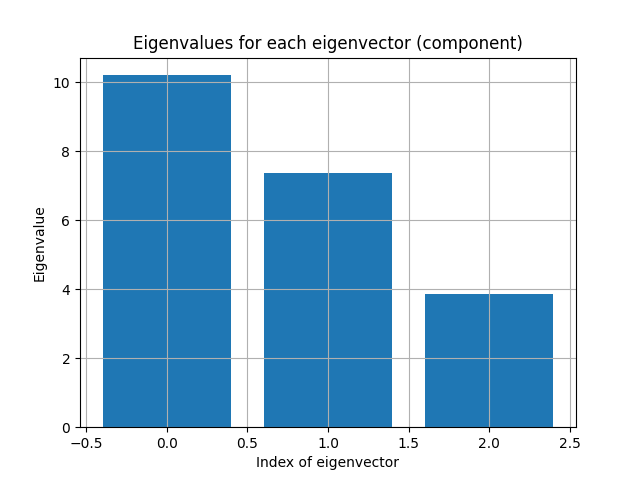

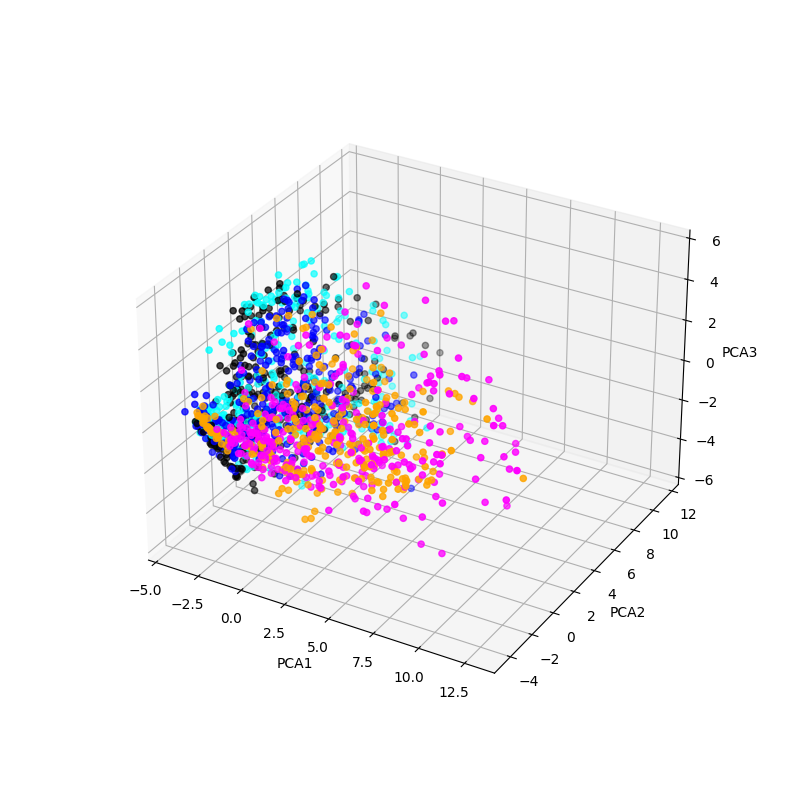

In [7]:
# ---------------------------------------------------------------------------------
# PCA
%matplotlib widget
J = 3
pca = PCA(n_components= J)

X_pca_fft = GlobVar.df_records["y_fft"].tolist()
check_me = pca.fit(X_pca_fft)
var = check_me.explained_variance_
indices = [each for each in range(var.size)]
plt.figure()
plt.bar(indices, height=var)
plt.grid()
plt.xlabel("Index of eigenvector")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues for each eigenvector (component)")
plt.show()

train_pca = pca.transform(X_pca_fft)

keys = {}
for i in range(J):
    ii = i+1
    keys[str(ii)] = train_pca[:, i]

train_pca = pd.DataFrame(keys)
# train_pca = pd.DataFrame({'First': train_pca[:, 0], 'Second': train_pca[:, 1], 'Third': train_pca[:, 2]})

train_pca = train_pca.join(GlobVar.df_records["number_vec"])
train_pca = train_pca.join(GlobVar.df_records["number"])

if J == 3:
    colors = {0:'blue', 1:'magenta', 2:'black', 3:'cyan', 4:'orange', 5:'green', 6:'red', 7:'purple', 8:'brown', 9:'pink'}

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter3D(train_pca['1'], train_pca['2'], train_pca['3'], c=train_pca['number'].map(colors))

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.show()

As we can see our data with NxF dimensions (N - number of samples and F number of each frequency) has been reduced to matrix NxJ (where J is number of PCA components). Eigenvalues for those components are relatively high so let's consider greater amount of them:

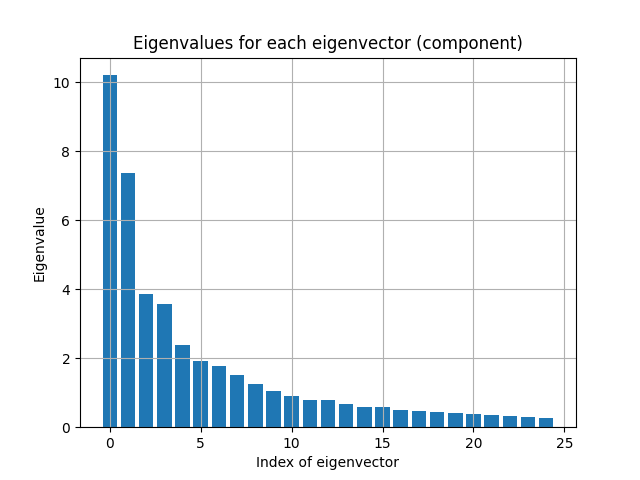

In [11]:
# ---------------------------------------------------------------------------------
# PCA
J = 25
pca = PCA(n_components= J)

X_pca_fft = GlobVar.df_records["y_fft"].tolist()
check_me = pca.fit(X_pca_fft)
var = check_me.explained_variance_
indices = [each for each in range(var.size)]
plt.figure()
plt.bar(indices, height=var)
plt.grid()
plt.xlabel("Index of eigenvector")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues for each eigenvector (component)")
plt.show()

train_pca = pca.transform(X_pca_fft)

keys = {}
for i in range(J):
    ii = i+1
    keys[str(ii)] = train_pca[:, i]

train_pca = pd.DataFrame(keys)

train_pca = train_pca.join(GlobVar.df_records["number_vec"])
train_pca = train_pca.join(GlobVar.df_records["number"])

if J == 3:
    colors = {0:'blue', 1:'magenta', 2:'black', 3:'cyan', 4:'orange', 5:'green', 6:'red', 7:'purple', 8:'brown', 9:'pink'}

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter3D(train_pca['1'], train_pca['2'], train_pca['3'], c=train_pca['number'].map(colors))

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.show()

Here we can notice that the eigenvalues for eigenvectors of indices 20 and more are not so different. That is why we will remain this number of components.

For now we have our input data prepared. It's time to implement our recognition model.

Epoch 1/200
40/40 - 0s - loss: 1.6398 - accuracy: 0.2047 - val_loss: 1.6275 - val_accuracy: 0.1733 - 442ms/epoch - 11ms/step
Epoch 2/200
40/40 - 0s - loss: 1.6014 - accuracy: 0.2047 - val_loss: 1.5979 - val_accuracy: 0.1733 - 83ms/epoch - 2ms/step
Epoch 3/200
40/40 - 0s - loss: 1.5808 - accuracy: 0.2220 - val_loss: 1.5736 - val_accuracy: 0.2400 - 74ms/epoch - 2ms/step
Epoch 4/200
40/40 - 0s - loss: 1.5577 - accuracy: 0.2784 - val_loss: 1.5453 - val_accuracy: 0.3422 - 95ms/epoch - 2ms/step
Epoch 5/200
40/40 - 0s - loss: 1.5260 - accuracy: 0.4322 - val_loss: 1.5064 - val_accuracy: 0.4578 - 68ms/epoch - 2ms/step
Epoch 6/200
40/40 - 0s - loss: 1.4844 - accuracy: 0.5482 - val_loss: 1.4590 - val_accuracy: 0.5956 - 70ms/epoch - 2ms/step
Epoch 7/200
40/40 - 0s - loss: 1.4352 - accuracy: 0.6392 - val_loss: 1.4075 - val_accuracy: 0.5956 - 68ms/epoch - 2ms/step
Epoch 8/200
40/40 - 0s - loss: 1.3870 - accuracy: 0.6196 - val_loss: 1.3608 - val_accuracy: 0.6089 - 67ms/epoch - 2ms/step
Epoch 9/200
40

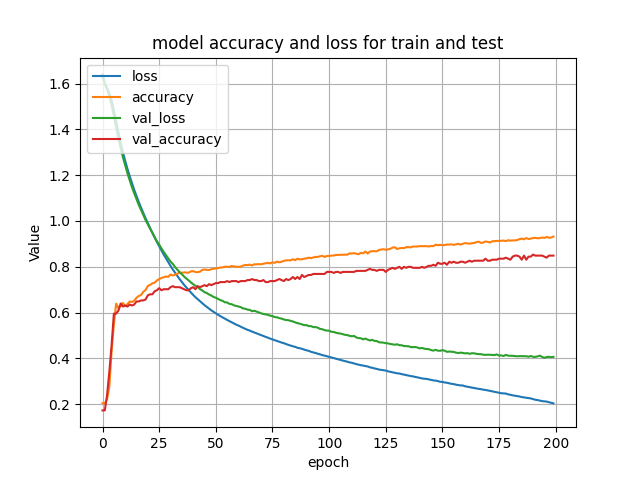

In [12]:

# ---------------------------------------------------------------------------------
# Neural Network

df_train, df_test = train_test_split(train_pca, train_size=0.85)
activ = "sigmoid"
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(J)),
    tf.keras.layers.Dense(100, activation=activ),
    tf.keras.layers.Dense(25, activation=activ),
    tf.keras.layers.Dense(8, activation=activ),
    # tf.keras.layers.Dense(4, activation=activ),
    tf.keras.layers.Dense(LABEL_NUMBER, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

X = df_train.iloc[:, [each for each in range(J)]].values.tolist()
Y = df_train["number_vec"].tolist()

X_test = df_test.iloc[:, [each for each in range(J)]].values.tolist()
Y_test = df_test["number_vec"].tolist()

save_or_load = 1
if save_or_load == 1:
    history = model.fit(x=X, y=Y, epochs=200,verbose=2, validation_data=(X_test,Y_test))
    print(history.history.keys())
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy and loss for train and test')
    plt.ylabel('Value')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy','val_loss', 'val_accuracy'], loc='upper left')
    plt.grid()
    plt.show()
    # model.save("model.h")
if save_or_load == 2:
    # model = tf.keras.models.load_model('model.h')
    pass

For now we will try to print cross-tabulation for exact and predicted digits:

In [ ]:

print(model.evaluate(X_test, Y_test))

print_crosstab(X_test, Y_test, model)


In [14]:
!jupytext --to markdown notebook

Traceback (most recent call last):
  File "/home/krystian/CODE/CODE_REPOS/PYTHON_EDU/AIML/NN/venv/bin/jupytext", line 8, in <module>
    sys.exit(jupytext())
  File "/home/krystian/CODE/CODE_REPOS/PYTHON_EDU/AIML/NN/venv/lib/python3.8/site-packages/jupytext/cli.py", line 488, in jupytext
    exit_code += jupytext_single_file(nb_file, args, log)
  File "/home/krystian/CODE/CODE_REPOS/PYTHON_EDU/AIML/NN/venv/lib/python3.8/site-packages/jupytext/cli.py", line 513, in jupytext_single_file
    bp = base_path(nb_file, args.input_format)
  File "/home/krystian/CODE/CODE_REPOS/PYTHON_EDU/AIML/NN/venv/lib/python3.8/site-packages/jupytext/paired_paths.py", line 48, in base_path
    raise InconsistentPath(
jupytext.paired_paths.InconsistentPath: 'notebook' is not a notebook. Supported extensions are '.ipynb', '.md', '.markdown', '.Rmd', '.py', '.coco', '.R', '.r', '.jl', '.cpp', '.ss', '.clj', '.scm', '.sh', '.ps1', '.q', '.m', '.wolfram', '.pro', '.js', '.ts', '.scala', '.rs', '.robot', '.resour